In [1]:
import pandas as pd
import math
import os
import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, IntegerLookup, CategoryEncoding
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.10.0
Num GPUs Available:  1


# Initiate TF Data Pipeline

In [2]:
#csv file
csv_file_path = 'C:/Users/boypa/OneDrive - The University of Auckland/ML Project/Credit Default/default of credit card clients.csv'

#check num of rows
nrows = len(pd.read_csv(csv_file_path))

# col and labels
label_name = "Y"
col_names = ['Unnamed: 0']+[f"X{i}" for i in range(1,24)]+[label_name]
unwanted_cols = ['Unnamed: 0']


#process csv row 
def process_csv(row_data):
    label = row_data.pop(label_name)  
    features = row_data   
    for unwanted_col in unwanted_cols:
        features.pop(unwanted_col)
    return features, label

#start the data piepline
dataset = tf.data.experimental.make_csv_dataset(
    csv_file_path,
    column_names=col_names,
    batch_size =1,
    shuffle=False,
    ignore_errors=True,
    )

#start the data piepline, unbatch for splitting
dataset = dataset.map(process_csv)

#split, batch again
train_size = int(nrows*0.6)
val_size = int(nrows*0.2)
test_size = int(nrows*0.2)

#dataset_train_val = dataset.take(train_size+val_size)
dataset_train_val = dataset.take(train_size+val_size).shuffle(buffer_size=100000)

batch_size = 32
train_ds = dataset_train_val.take(train_size).batch(batch_size)
val_ds = dataset_train_val.skip(train_size).take(val_size).batch(batch_size)
test_ds = dataset.skip(train_size+val_size).take(test_size).batch(batch_size)


# Preprocessing

## Create normalization and encoding layer

In [3]:
# types of features (for transformation)
continuous_features = ['X1','X5']+[f'X{i}' for i in range(12,24)]
categorical_features = [i for i in col_names if i not in continuous_features+unwanted_cols+[label_name]]

# fn to transform continuous features
def preproc_layer_norm(name, dataset):
    normalizer = Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: tf.cast(x[name], tf.float32)).unbatch()  
    normalizer.adapt(feature_ds)
    return normalizer
# fn to transform cat features
def prepoc_layer_categorical(name, dataset, max_tokens=None):
    index = IntegerLookup(max_tokens=max_tokens)
    feature_ds = dataset.map(lambda x, y: tf.cast(x[name], tf.int32)).unbatch() 
    index.adapt(feature_ds)
    cat_encoder = CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    return lambda feature: cat_encoder(index(feature))

# apply preproc with train data. Put in preprocessing layer dict
prepoc_layer_dict = {}
for name in continuous_features:
    prepoc_layer_dict.update({name: preproc_layer_norm(name, train_ds)})
    print(f'finish with feature {name}')
for name in categorical_features:
    prepoc_layer_dict.update({name: prepoc_layer_categorical(name, train_ds)})
    print(f'finish with feature {name}')


finish with feature X1
finish with feature X5
finish with feature X12
finish with feature X13
finish with feature X14
finish with feature X15
finish with feature X16
finish with feature X17
finish with feature X18
finish with feature X19
finish with feature X20
finish with feature X21
finish with feature X22
finish with feature X23
finish with feature X2
finish with feature X3
finish with feature X4
finish with feature X6
finish with feature X7
finish with feature X8
finish with feature X9
finish with feature X10
finish with feature X11


## Normalize and Encode

In [4]:
def preproc_fn(features, label):
    processed_features = []
    for name in continuous_features:
        feature = prepoc_layer_dict[name](tf.cast(features[name], tf.float32))
        feature = tf.reshape(feature, [-1, 1])  
        processed_features.append(feature)
    for name in categorical_features:
        cat_feature = prepoc_layer_dict[name](tf.cast(features[name], tf.int32))
        processed_features.append(cat_feature) 
    #concat the features
    features_concat = tf.concat(processed_features, axis=-1)
    return features_concat, label
train_ds_preproc = train_ds.map(lambda x,y: preproc_fn(x,y))    
val_ds_preproc =  val_ds.map(lambda x,y: preproc_fn(x,y))
test_ds_preproc =  test_ds.map(lambda x,y: preproc_fn(x,y)) 

# Create model

In [5]:
#check shape
for batch_features, batch_labels in train_ds_preproc.take(1):
    input_shape = batch_features.shape[1:] 

#create model
model = models.Sequential()
model.add(layers.InputLayer(input_shape = input_shape))
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

#schedule learning rate
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps= 1000,
    decay_rate=0.95
)
optimizer = Adam(learning_rate=lr_schedule)

#compile model
model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['AUC', 'Precision', 'Recall'])

#train 
history = model.fit(train_ds_preproc, 
                    epochs=60,  
                    validation_data = val_ds_preproc
                   )
                    

Epoch 1/60
563/563 [==============================] - 8s 11ms/step - loss: 0.4505 - auc: 0.7528 - precision: 0.6567 - recall: 0.3100 - val_loss: 0.4305 - val_auc: 0.7844 - val_precision: 0.6691 - val_recall: 0.4072
Epoch 2/60
563/563 [==============================] - 6s 10ms/step - loss: 0.4380 - auc: 0.7665 - precision: 0.6779 - recall: 0.3512 - val_loss: 0.4367 - val_auc: 0.7821 - val_precision: 0.6933 - val_recall: 0.3500
Epoch 3/60
563/563 [==============================] - 6s 10ms/step - loss: 0.4361 - auc: 0.7686 - precision: 0.6801 - recall: 0.3467 - val_loss: 0.4337 - val_auc: 0.7840 - val_precision: 0.7022 - val_recall: 0.3280
Epoch 4/60
563/563 [==============================] - 6s 10ms/step - loss: 0.4307 - auc: 0.7784 - precision: 0.6844 - recall: 0.3500 - val_loss: 0.4359 - val_auc: 0.7922 - val_precision: 0.7161 - val_recall: 0.3215
Epoch 5/60
563/563 [==============================] - 6s 10ms/step - loss: 0.4338 - auc: 0.7777 - precision: 0.6868 - recall: 0.3526 - val_l

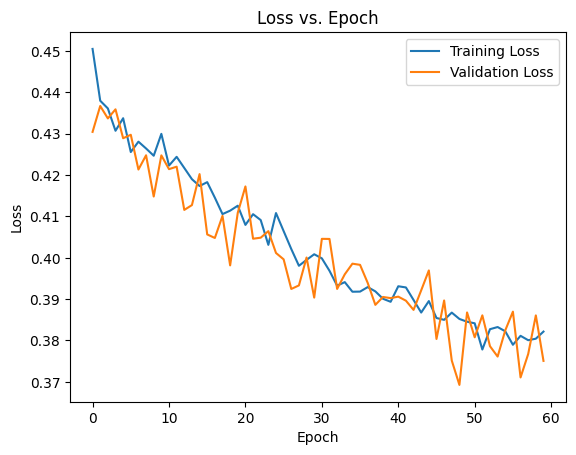

In [6]:
# epoch vs loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

# Evaluate

In [7]:
results = model.evaluate(test_ds_preproc)

188/188 [==============================] - 2s 7ms/step - loss: 0.4667 - auc: 0.7557 - precision: 0.6410 - recall: 0.3088


## Create ROC curve

188/188 [==============================] - 1s 3ms/step


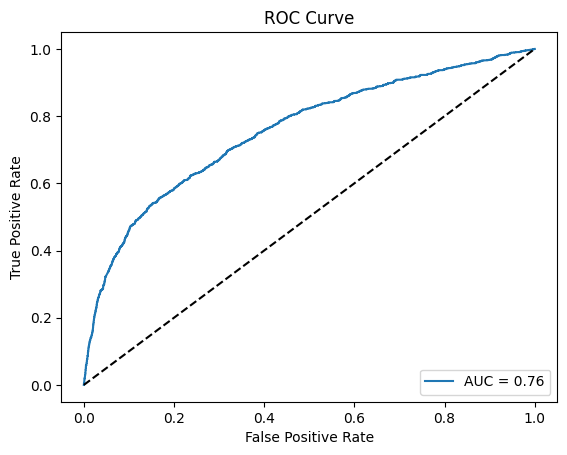

In [9]:
y_pred = model.predict(test_ds_preproc)
y_pred_flat = y_pred.flatten()
y_true = np.concatenate([y for x, y in test_ds_preproc], axis=0)
#calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_flat)
auc_score = auc(fpr, tpr)
#plot ROC
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [10]:
!git config --global user.name "bpardosi"
!git config --global user.email "boypardosi@yahoo.co.id"
